In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from particle_filter import filter
from models import SEIR_model,SEIR_Obs
from pmcmc import PMCMC
from scipy.stats import beta

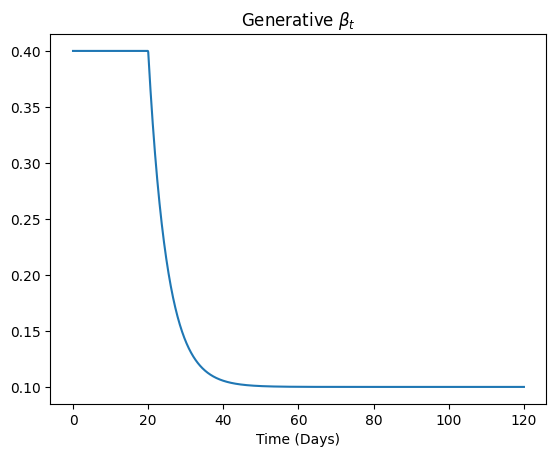

In [2]:
'''Simulated Data, setting up the SIR model'''

rng = np.random.default_rng(0)

gamma = 1/14
eta = 1/7
q = 0.1
mu = 0.004
rho = 0.1

T = 120
dt = 0.1
t_vec = np.linspace(0,T,T * int(1/dt))

N = 100_000
I = 5
E = 5


beta_par = {'b_0':0.4,'b_inf': 0.1, 'tau': 5,'T':20}

def beta_sim(par,t):
    if(t < par['T']):
        return 0.4
    
    return par['b_inf'] + (par['b_0'] - par['b_inf']) * np.exp(-(t - par['T'])/par['tau'])

betas = np.array([beta_sim(beta_par,t) for t in t_vec])

state = np.zeros((4,len(t_vec)))
state[:,0] = np.array([N - I - E,E, I, 0])

plt.title('Generative $\\beta_t$')
plt.xlabel('Time (Days)')
plt.plot(t_vec,betas)

for time_index in range(1,len(t_vec)):

    new_E = rng.poisson((betas[time_index - 1] * (state[1,time_index -1] + q * state[2,time_index - 1]) * state[0,time_index - 1]/np.sum(state[:,time_index-1])) * dt)
    new_I = rng.poisson((eta * state[1,time_index - 1]) * dt)
    new_ER = rng.poisson((gamma * state[1,time_index -1]) * dt)
    new_IR = rng.poisson((gamma * state[2,time_index - 1]) * dt)
    new_D = rng.poisson((mu * state[2,time_index - 1]) * dt)

    state[0,time_index] = np.maximum(0.,state[0,time_index - 1] - new_E) #S 

    state[1,time_index] = np.maximum(0.,state[1,time_index - 1] + new_E - new_I - new_ER) #E

    state[2,time_index] = np.maximum(0.,state[2,time_index-1] + new_I - new_IR - new_D) #I

    state[3,time_index] = np.maximum(0.,state[3,time_index - 1] + new_ER + new_IR)


    

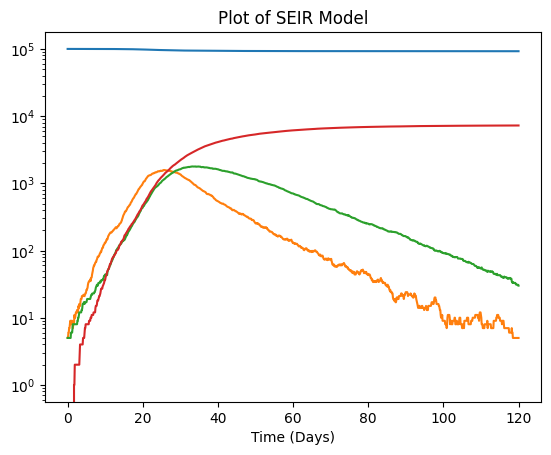

In [3]:
plt.yscale('log')
plt.title('Plot of SEIR Model')
plt.xlabel('Time (Days)')
plt.plot(t_vec,state.T)

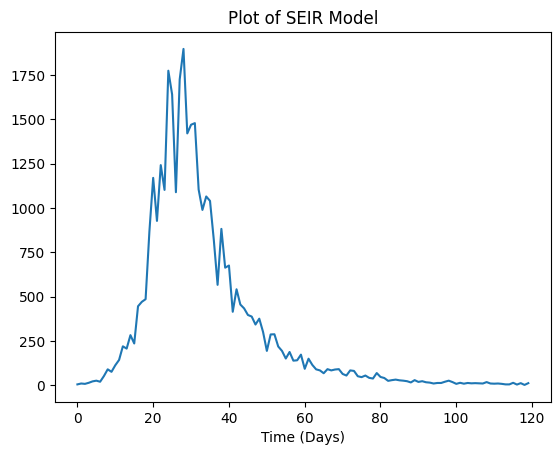

In [4]:
n = 40

data = rng.negative_binomial(p = n/(state[1,::int(1/dt)] + n),n = n)
plt.title('Plot of SEIR Model')
plt.xlabel('Time (Days)')
plt.plot(t_vec[::int(1/dt)],data)

In [5]:
particles, weights,likelihood = filter(data = data,
                              theta= (gamma,eta),
                              rng = rng,
                              num_particles = 1000,
                              dt = 0.1,
                              model = SEIR_model,
                              observation=SEIR_Obs,
                              model_dim = 5,
                              observation_dim=1)

-776.8100238880584


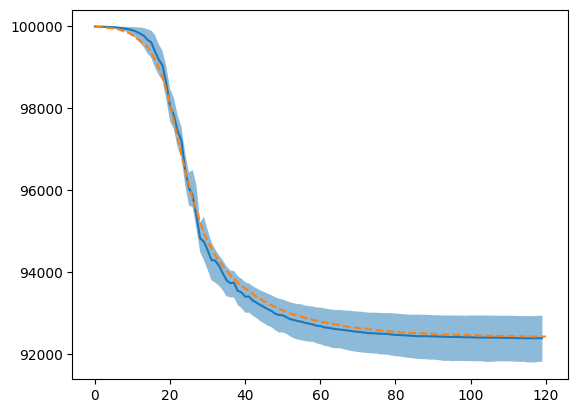

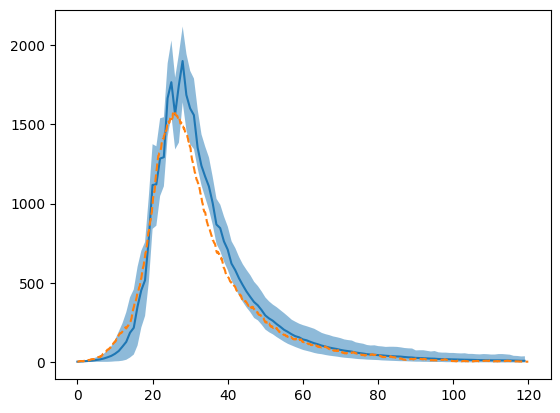

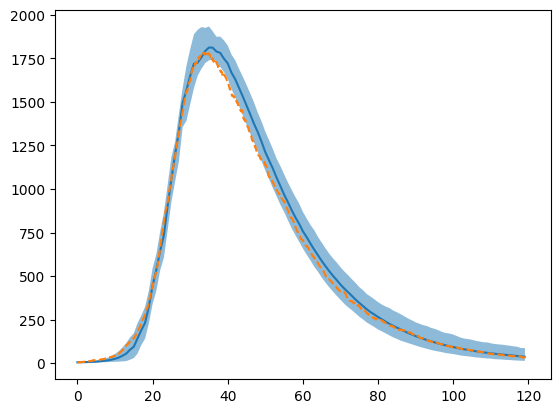

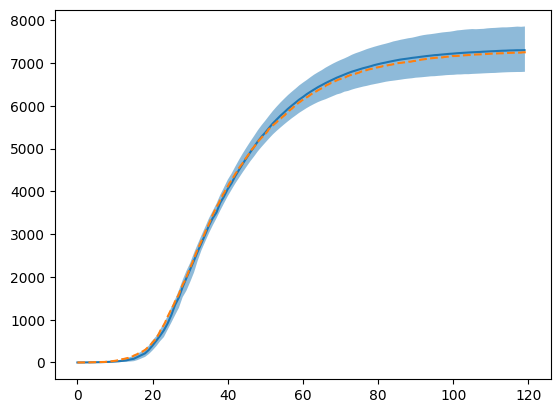

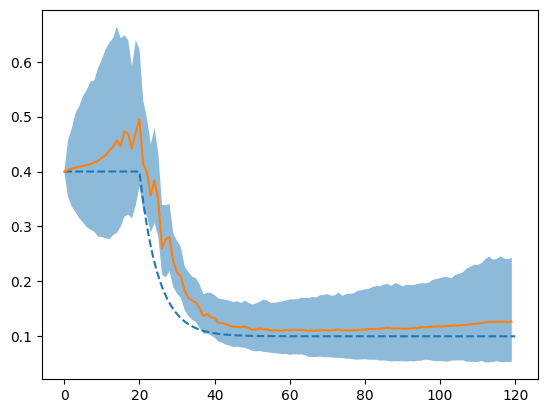

: 

In [6]:
print(np.sum(np.log(likelihood)))

for i in range(4):
    plt.fill_between(t_vec[::int(1/dt)],np.percentile(particles[:,i,:].T,5,axis = 1),np.percentile(particles[:,i,:].T,95,axis = 1),alpha = 0.5)
    plt.plot(np.average(particles[:,i,:],weights = weights,axis = 0))
    plt.plot(t_vec,state[i,:].T,'--')
    plt.show()

plt.plot(t_vec,betas,'--')
plt.fill_between(t_vec[::int(1/dt)],np.percentile(particles[:,4,:].T,5,axis = 1),np.percentile(particles[:,4,:].T,95,axis = 1),alpha = 0.5)
plt.plot(np.average(particles[:,4,:],weights = weights,axis = 0))


In [7]:
pmcmc_rng = np.random.default_rng(10)

iterations = 10_000

num_particles = 1000

@nb.njit
def uniform_numba_logpdf(theta,min_val,max_val):

    if(theta < max_val and theta > min_val):
        return np.log(1/(max_val - min_val))
    
    return np.log(0.)


def prior(theta):
    return beta.logpdf(theta[0],a = 2.,b = 10.) + beta.logpdf(theta[1],a = 2.,b = 10.) #+ uniform_numba_logpdf(theta[2],0.,1000.)

theta, LL, pf_means = PMCMC(iterations=iterations,
                  num_particles=num_particles,
                  init_theta=np.array([0.2,0.3]),
                  data = data,
                  rng = pmcmc_rng,
                  dt = 0.1, 
                  prior = prior, 
                  model = SEIR_model,
                  observation = SEIR_Obs,
                  model_dim=5,
                  observation_dim=1)




iteration: 10| Acceptance rate: 0.1| Log-Likelihood: -775.5969993981329| Proposal [0.31458203 0.19297035]
iteration: 20| Acceptance rate: 0.15| Log-Likelihood: -771.6739221462212| Proposal [0.14001192 0.11903537]
iteration: 30| Acceptance rate: 0.26666666666666666| Log-Likelihood: -772.5801080250404| Proposal [0.14191355 0.17526965]
iteration: 40| Acceptance rate: 0.375| Log-Likelihood: -772.5671016856338| Proposal [0.24566813 0.05508662]
iteration: 50| Acceptance rate: 0.4| Log-Likelihood: -771.9181533007678| Proposal [0.22652138 0.08860317]
iteration: 60| Acceptance rate: 0.4166666666666667| Log-Likelihood: -772.1454562532068| Proposal [0.19334645 0.17478497]
iteration: 70| Acceptance rate: 0.44285714285714284| Log-Likelihood: -772.4421600482091| Proposal [0.14094204 0.20099078]
iteration: 80| Acceptance rate: 0.425| Log-Likelihood: -772.3714997433733| Proposal [0.14173288 0.23698649]
iteration: 90| Acceptance rate: 0.43333333333333335| Log-Likelihood: -773.0834654666526| Proposal [0

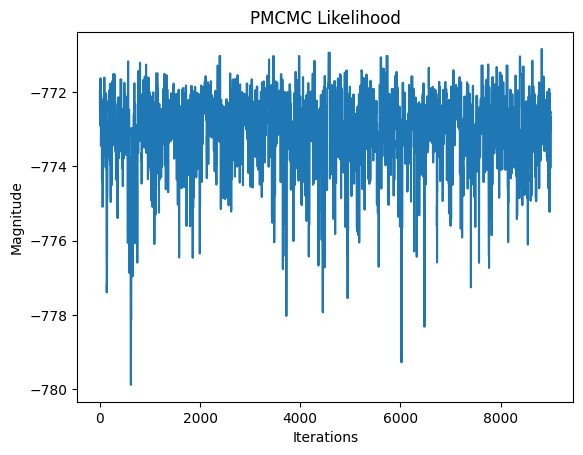

In [ ]:
burn_in = 1000

plt.title("PMCMC Likelihood")
plt.ylabel("Magnitude")
plt.xlabel("Iterations")
plt.plot(LL[burn_in:])

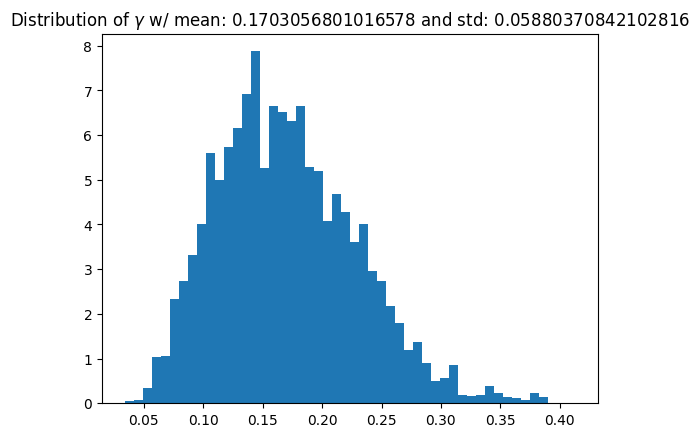

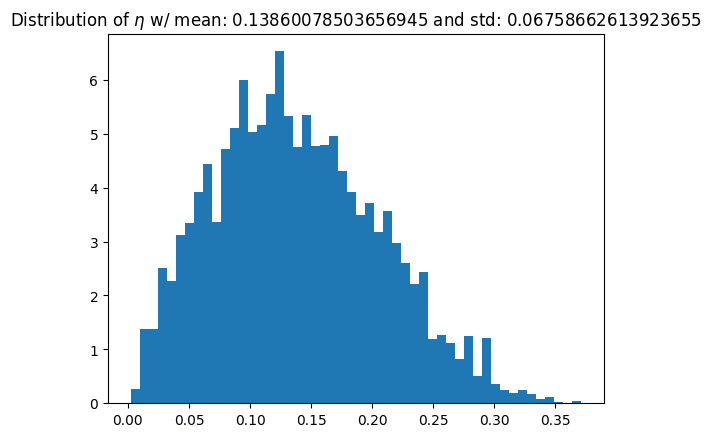

In [ ]:
plt.title(f"Distribution of $\\gamma$ w/ mean: {np.mean(theta[0,burn_in:])} and std: {np.std(theta[0,burn_in:])}")
plt.hist(theta[0,burn_in:],density=True,bins = 50)
plt.show()

plt.title(f"Distribution of $\\eta$ w/ mean: {np.mean((theta[1,burn_in:]))} and std: {np.std((theta[1,burn_in:]))}")
plt.hist((theta[1,burn_in:]),density=True,bins = 50)
plt.show()

# plt.title(f"Distribution of $\\sigma$ w/ mean: {np.mean(theta[2,burn_in:])} and std: {np.std(theta[2,burn_in:])}")
# plt.hist(theta[2,burn_in:],density=True,bins = 50)
# plt.show()




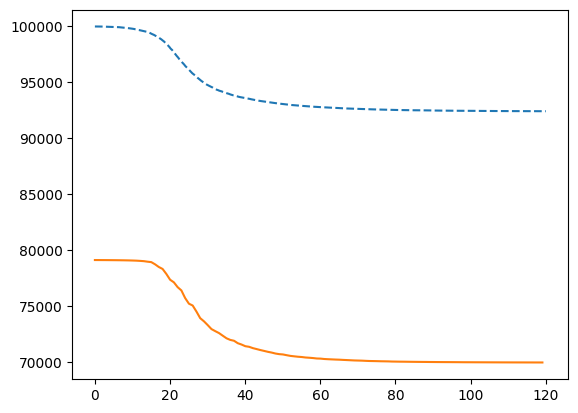

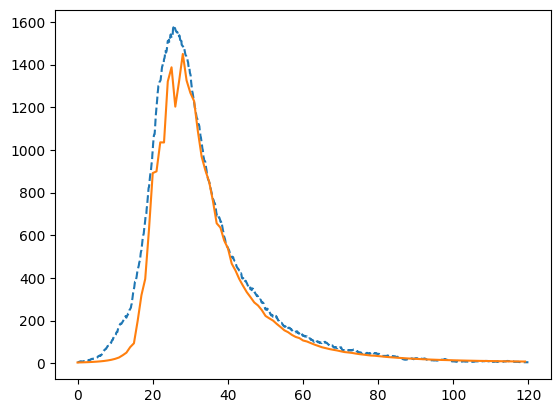

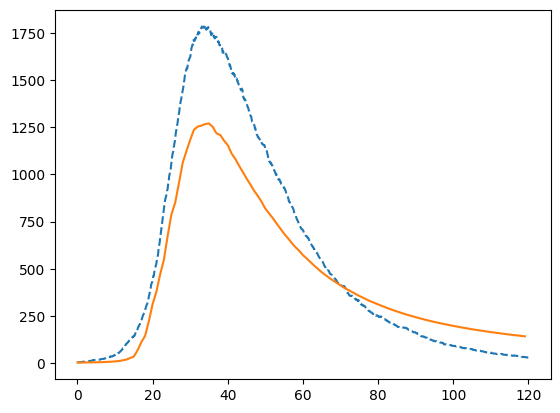

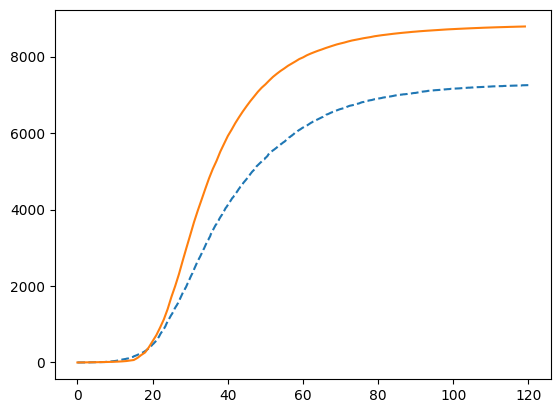

In [ ]:

for i in range(4):
    plt.plot(t_vec,state[i,:].T,'--')
    plt.plot(t_vec[::int(1/dt)],np.mean(pf_means[i,:,burn_in:],axis = 1))
    plt.show()

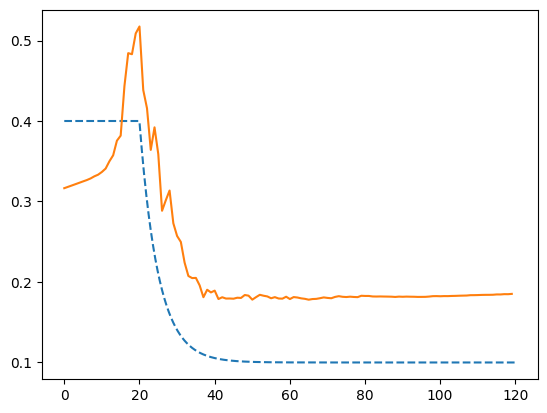

In [ ]:
plt.plot(t_vec,betas,'--')
plt.plot(t_vec[::int(1/dt)],np.mean(pf_means[4,:,burn_in:],axis = 1))
plt.show()